In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as graph

from itertools import zip_longest
from scipy import misc
from keras import layers, models
from keras.optimizers import RMSprop
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

base_dir =  'Data/CatsvDogs/Train/'

train_dir = 'Data/CatsvDogs/Train/Train'
val_dir = 'Data/CatsvDogs/Train/Val'
test_dir = 'Data/CatsvDogs/Train/Test'

train_range = range(1000)
val_range = range(1000, 1500)
test_range = range(1500, 2000)

def iterate_until(iterable, n):
    i = 0
    for thing in iterable:
        if i >= n:
            raise StopIteration
        
        i += 1
        yield thing

/home/harshil/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
# Move files to respective directories
def copy_files_to_dir(src, name, base=base_dir):
    destination = base + src
    if os.path.exists(destination) is False:
        os.makedirs(destination)
    
    shutil.copyfile(base + name, destination + name)


for animal in ['Cat', 'Dog']:
    for i in train_range:
        copy_files_to_dir(f'Train/{animal}/', f'{animal.lower()}.{i}.jpg')

    for i in val_range:
        copy_files_to_dir(f'Val/{animal}/', f'{animal.lower()}.{i}.jpg')
    
    for i in test_range:
        copy_files_to_dir(f'Test/{animal}/', f'{animal.lower()}.{i}.jpg')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(32, 150, 150, 3)


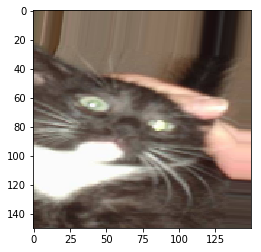

(32, 150, 150, 3)


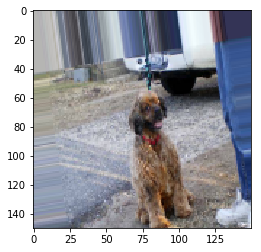

(32, 150, 150, 3)


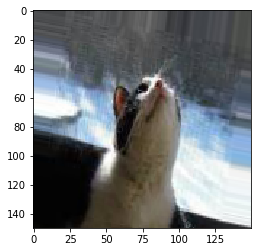

(32, 150, 150, 3)


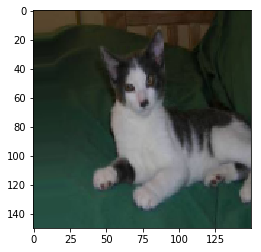

/home/harshil/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: generator 'iterate_until' raised StopIteration


In [2]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Generator of train images, will come in shape (20, 150, 150, 3)
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_gen = ImageDataGenerator(rescale=1/255).flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

for batch in iterate_until(train_gen, 4):
    print(batch[0].shape)
    graph.imshow(batch[0][0])
    graph.show()

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [4]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['acc']
)

checkpoint = ModelCheckpoint('weights.best.hdf5', monitor='val_acc', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_acc', patience=5)

callbacks_list = [checkpoint, early_stop]

In [6]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=100,
    validation_data=val_gen,
    validation_steps=50,
    callbacks=callbacks_list
)

Epoch 1/100
100/100 [==============================] - 197s 2s/step - loss: 0.6699 - acc: 0.5866 - val_loss: 0.6457 - val_acc: 0.6142

Epoch 00001: val_acc improved from 0.60850 to 0.61421, saving model to weights.best.hdf5
Epoch 2/100
100/100 [==============================] - 192s 2s/step - loss: 0.6548 - acc: 0.6038 - val_loss: 0.6460 - val_acc: 0.6079

Epoch 00002: val_acc did not improve
Epoch 3/100
100/100 [==============================] - 192s 2s/step - loss: 0.6407 - acc: 0.6309 - val_loss: 0.6161 - val_acc: 0.6478

Epoch 00003: val_acc improved from 0.61421 to 0.64784, saving model to weights.best.hdf5
Epoch 4/100
100/100 [==============================] - 193s 2s/step - loss: 0.6262 - acc: 0.6522 - val_loss: 0.5916 - val_acc: 0.6669

Epoch 00004: val_acc improved from 0.64784 to 0.66688, saving model to weights.best.hdf5
Epoch 5/100
100/100 [==============================] - 192s 2s/step - loss: 0.6115 - acc: 0.6541 - val_loss: 0.5877 - val_acc: 0.6631

Epoch 00005: val_acc 

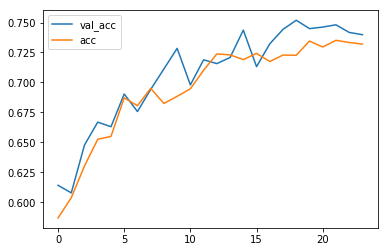

In [7]:
for key, value in history.history.items():
    if 'acc' in key:
        graph.plot(value, label=key)
graph.legend()
graph.show()

In [ ]:
model.save('cats_and_dogs_small_2.h5')

# Use a pretained network

In [ ]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [ ]:
conv_base.summary()

In [ ]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    datagen = ImageDataGenerator(rescale=1/255)
    batch_size = 20
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
    )
    
    n_iterations = sample_count / batch_size
    for i, (inputs_batch, labels_batch) in enumerate(iterate_until(generator, n_iterations)):
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size]  = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        
    return features, labels
        
train_features, label_features = extract_features(train_dir, 2000)
val_features, val_labels = extract_features(val_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

In [ ]:
train_features = train_features.reshape(2000, np.prod(train_features.shape[1:]))
val_features = val_features.reshape(1000, np.prod(val_features.shape[1:]))
test_features = test_features.reshape(1000, np.prod(test_features.shape[1:]))

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(2000, 8192)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'],
)
model.summary()

In [ ]:
train_labels = label_features

history = model.fit(
    train_features, train_labels,
    epochs = 30,
    batch_size=20,
    validation_data =(val_features, val_labels),
)

In [ ]:
train_features = train_features.reshape(2000, np.prod(train_features.shape[1:]))

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()